# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_density_and_log"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.008623,0.009576,-0.900478,0.367900,0.816050,random.pheno988
1,LV2,0.027041,0.012462,2.169890,0.030052,0.015026,random.pheno988
2,LV3,-0.012285,0.012284,-1.000094,0.317303,0.841349,random.pheno988
3,LV4,-0.015225,0.011943,-1.274879,0.202398,0.898801,random.pheno988
4,LV5,0.005240,0.012754,0.410879,0.681175,0.340587,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06432624113475177

# QQ-plot

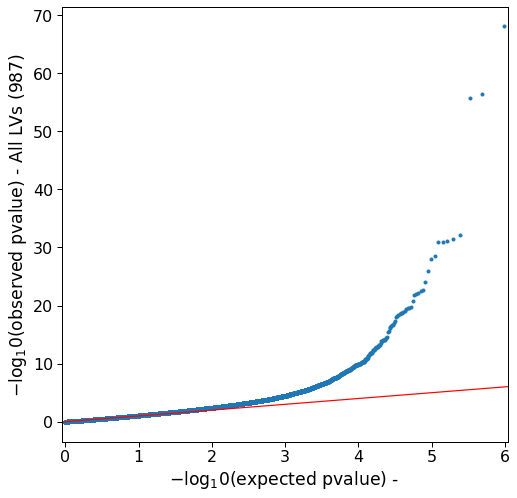

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.025,0.057
1,LV10,0.008,0.050,0.087
2,LV100,0.011,0.031,0.065
3,LV101,0.007,0.042,0.085
4,LV102,0.016,0.061,0.105


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.019139,0.064326,0.113728
std,0.017958,0.029753,0.038709
min,0.000000,0.006000,0.022000
25%,0.011000,0.048000,0.091000
50%,0.016000,0.060000,0.109000
75%,0.022000,0.073500,0.128500
max,0.244000,0.341000,0.402000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(62, 4)

,lv,1,5,10
448,LV502,0.016,0.049,0.090
508,LV557,0.014,0.049,0.092
395,LV455,0.011,0.049,0.087
380,LV441,0.011,0.049,0.093
592,LV632,0.016,0.049,0.088
288,LV359,0.010,0.049,0.089
258,LV331,0.011,0.049,0.090
618,LV656,0.014,0.049,0.091
624,LV661,0.009,0.049,0.086
490,LV540,0.016,0.049,0.095


,lv,1,5,10
407,LV466,0.012,0.050,0.095
348,LV412,0.010,0.050,0.096
128,LV214,0.013,0.051,0.102
857,LV871,0.011,0.051,0.101
892,LV902,0.013,0.051,0.102
49,LV143,0.019,0.051,0.093
91,LV181,0.011,0.051,0.092
940,LV946,0.016,0.051,0.089
139,LV224,0.020,0.051,0.096
699,LV729,0.013,0.051,0.115


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(473, 4)

,lv,1,5,10
423,LV480,0.072,0.154,0.217
129,LV215,0.075,0.165,0.224
613,LV651,0.046,0.166,0.261
153,LV237,0.085,0.173,0.240
349,LV413,0.107,0.177,0.231
255,LV329,0.136,0.183,0.211
965,LV969,0.104,0.186,0.263
682,LV713,0.103,0.188,0.249
549,LV594,0.119,0.192,0.242
401,LV460,0.111,0.192,0.252


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017358,0.010316,1.682603,0.092501,0.046250,random.pheno988
1031,LV45,0.010536,0.010319,1.020947,0.307318,0.153659,random.pheno589
2018,LV45,0.005023,0.010318,0.486842,0.626387,0.313194,random.pheno385
3005,LV45,0.006548,0.010307,0.635300,0.525255,0.262628,random.pheno5
3992,LV45,-0.016240,0.010305,-1.575915,0.115094,0.942453,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.021

In [32]:
show_prop(results, 0.05)

0.063

In [33]:
show_prop(results, 0.10)

0.12

In [34]:
show_prop(results, 0.15)

0.164

In [35]:
show_prop(results, 0.20)

0.204

### QQplot

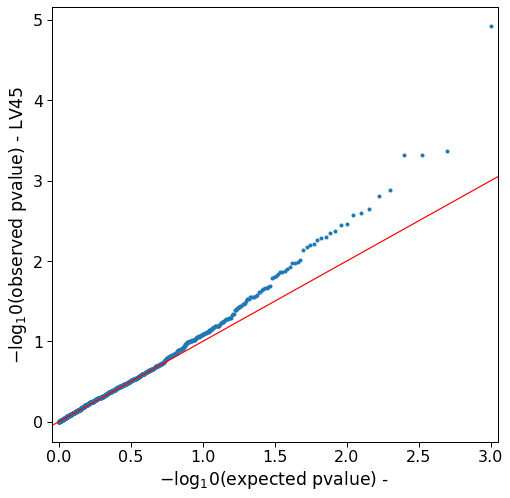

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020863,0.012353,1.688845,0.091298,0.045649,random.pheno988
1220,LV234,0.000766,0.012338,0.062107,0.950480,0.475240,random.pheno589
2207,LV234,-0.012137,0.012331,-0.984213,0.325048,0.837476,random.pheno385
3194,LV234,0.010070,0.012332,0.816599,0.414188,0.207094,random.pheno5
4181,LV234,0.002697,0.012361,0.218161,0.827311,0.413655,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
show_prop(results, 0.05)

0.063

In [44]:
show_prop(results, 0.10)

0.118

In [45]:
show_prop(results, 0.15)

0.152

In [46]:
show_prop(results, 0.20)

0.185

### QQplot

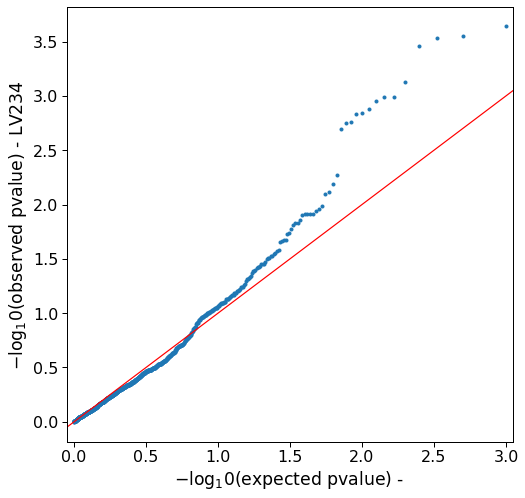

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.010632,0.012898,0.824312,0.409793,0.204897,random.pheno988
1833,LV847,0.003698,0.012917,0.286287,0.774668,0.387334,random.pheno589
2820,LV847,-0.014287,0.012900,-1.107547,0.268099,0.865951,random.pheno385
3807,LV847,0.008309,0.012884,0.644926,0.518998,0.259499,random.pheno5
4794,LV847,0.007957,0.012939,0.614982,0.538589,0.269294,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.024

In [54]:
show_prop(results, 0.05)

0.063

In [55]:
show_prop(results, 0.10)

0.103

In [56]:
show_prop(results, 0.15)

0.146

In [57]:
show_prop(results, 0.20)

0.193

### QQplot

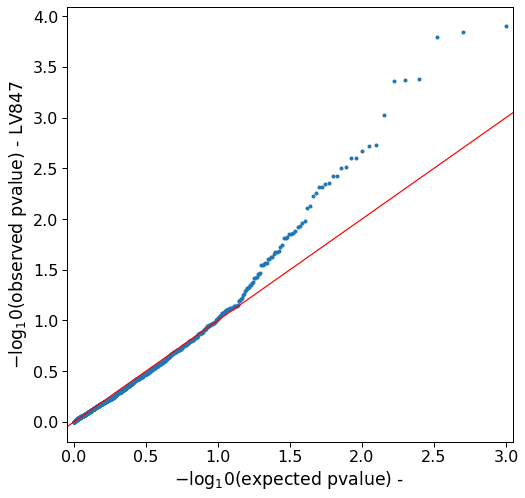

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.020268,0.013580,-1.492441,0.135633,0.932184,random.pheno988
1096,LV110,-0.007170,0.013586,-0.527766,0.597680,0.701160,random.pheno589
2083,LV110,-0.022621,0.013576,-1.666213,0.095720,0.952140,random.pheno385
3070,LV110,-0.010294,0.013536,-0.760471,0.447001,0.776500,random.pheno5
4057,LV110,-0.001068,0.013578,-0.078670,0.937297,0.531351,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.009

In [65]:
show_prop(results, 0.05)

0.037

In [66]:
show_prop(results, 0.10)

0.072

In [67]:
show_prop(results, 0.15)

0.117

In [68]:
show_prop(results, 0.20)

0.154

### QQplot

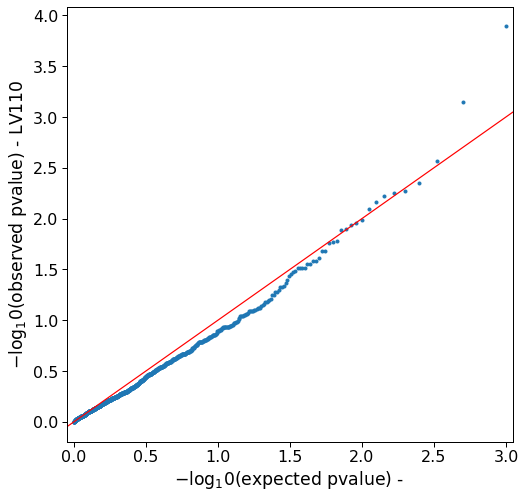

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014929,0.011848,1.260015,0.207710,0.103855,random.pheno988
1755,LV769,0.002298,0.011810,0.194590,0.845720,0.422860,random.pheno589
2742,LV769,0.002286,0.011828,0.193240,0.846777,0.423389,random.pheno385
3729,LV769,-0.015100,0.011823,-1.277094,0.201615,0.899192,random.pheno5
4716,LV769,-0.019912,0.011849,-1.680559,0.092897,0.953551,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.05

In [76]:
show_prop(results, 0.05)

0.141

In [77]:
show_prop(results, 0.10)

0.224

In [78]:
show_prop(results, 0.15)

0.291

In [79]:
show_prop(results, 0.20)

0.345

### QQplot

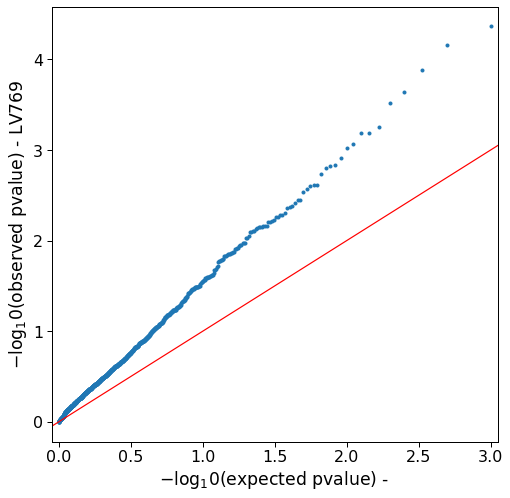

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.006409,0.014082,0.455097,0.649055,0.324528,random.pheno988
1786,LV800,-0.007284,0.014080,-0.517336,0.604940,0.697530,random.pheno589
2773,LV800,-0.002957,0.014103,-0.209655,0.833944,0.583028,random.pheno385
3760,LV800,-0.023526,0.014111,-1.667231,0.095517,0.952241,random.pheno5
4747,LV800,-0.012543,0.014052,-0.892615,0.372097,0.813952,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.008

In [87]:
show_prop(results, 0.05)

0.045

In [88]:
show_prop(results, 0.10)

0.083

In [89]:
show_prop(results, 0.15)

0.131

In [90]:
show_prop(results, 0.20)

0.182

### QQplot

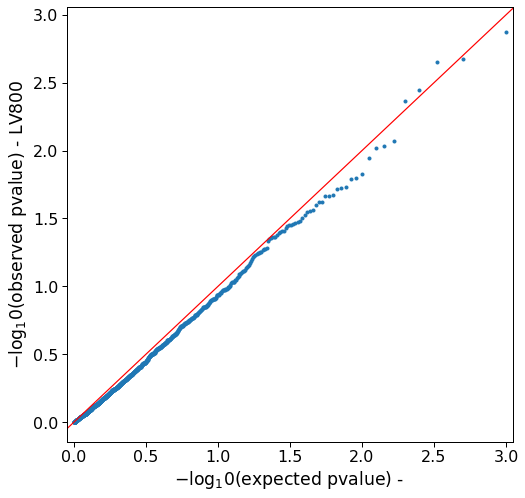

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
448,LV502,0.016,0.049,0.090
508,LV557,0.014,0.049,0.092
395,LV455,0.011,0.049,0.087
380,LV441,0.011,0.049,0.093
592,LV632,0.016,0.049,0.088
288,LV359,0.010,0.049,0.089
258,LV331,0.011,0.049,0.090
618,LV656,0.014,0.049,0.091
624,LV661,0.009,0.049,0.086
490,LV540,0.016,0.049,0.095


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.001502,0.010534,0.142597,0.886613,0.443307,random.pheno988
1398,LV412,-0.003045,0.010487,-0.290373,0.771540,0.614230,random.pheno589
2385,LV412,0.002735,0.010481,0.260949,0.794140,0.397070,random.pheno385
3372,LV412,-0.004583,0.010542,-0.434728,0.663775,0.668113,random.pheno5
4359,LV412,0.016146,0.010488,1.539501,0.123731,0.061866,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.01

In [100]:
show_prop(results, 0.05)

0.05

In [101]:
show_prop(results, 0.10)

0.096

In [102]:
show_prop(results, 0.15)

0.144

In [103]:
show_prop(results, 0.20)

0.18

### QQplot

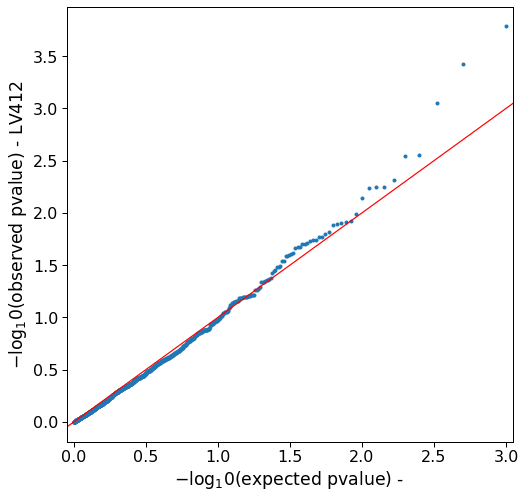

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.019080,0.012377,-1.541544,0.123234,0.938383,random.pheno988
1043,LV57,0.017291,0.012380,1.396660,0.162564,0.081282,random.pheno589
2030,LV57,0.019107,0.012385,1.542655,0.122964,0.061482,random.pheno385
3017,LV57,0.001282,0.012370,0.103617,0.917477,0.458738,random.pheno5
4004,LV57,0.013517,0.012346,1.094831,0.273632,0.136816,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.009

In [111]:
show_prop(results, 0.05)

0.057

In [112]:
show_prop(results, 0.10)

0.108

In [113]:
show_prop(results, 0.15)

0.144

In [114]:
show_prop(results, 0.20)

0.184

### QQplot

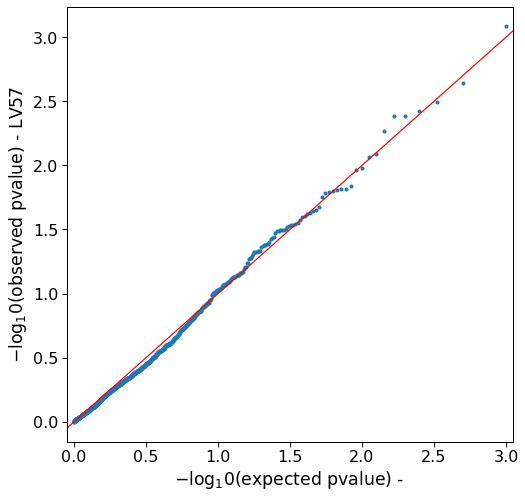

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007078,0.011494,-0.615801,0.538048,0.730976,random.pheno988
1633,LV647,0.013619,0.011493,1.184973,0.236072,0.118036,random.pheno589
2620,LV647,0.011118,0.011493,0.967351,0.333405,0.166702,random.pheno385
3607,LV647,0.001786,0.011493,0.155415,0.876499,0.438250,random.pheno5
4594,LV647,0.013637,0.011465,1.189398,0.234327,0.117164,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.023

In [122]:
show_prop(results, 0.05)

0.066

In [123]:
show_prop(results, 0.10)

0.116

In [124]:
show_prop(results, 0.15)

0.162

In [125]:
show_prop(results, 0.20)

0.202

### QQplot

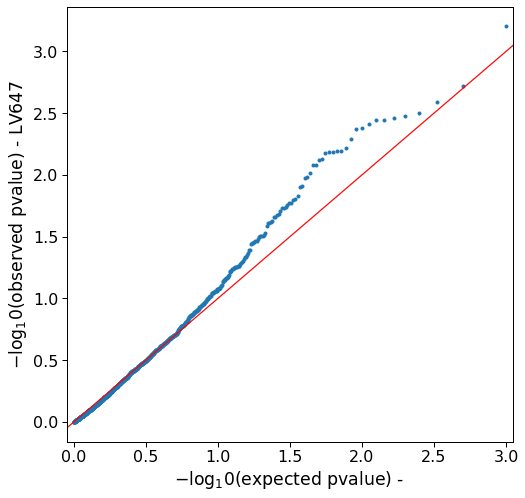

In [126]:
qqplot_unif(results)